# **Pratica de Data Science**
***
**Alunos:** 
- Mário Trentim - mht@cesar.school
- Tiago B. Lacerda - tbl@cesar.school
- Wellynton Diniz - wellyntondiniz@gmail.com

**Objetivo**: Classificar áudios entre voz masculina e voz feminina.

**Base de dados escolhida**: Google AudioSet. Áudios de 10s provenientes do Youtube

**Kaggle**: https://www.kaggle.com/akela91/google-audioset/code?datasetId=155702

----

Sobre o **Dataset:**

- Fabricamos um dataset baixando 1000 áudios de homens e 1000 de mulheres falando. Cada áudio tem duração fixa de 10 segundos e foram baixados do AUDIOSET (https://research.google.com/audioset/). O AudioSet tem origem nos videos do Youtube e que envolvem questões autorais, por este motivo, o google disponibiliza apenas *features* pre-processadas para uso no tensorflow. Felizmente, existem diversos scripts no github que automatizam o processo de baixar os áudios diretamente do youtube, a exemplo do que utilizamos (https://github.com/aoifemcdonagh/audioset-processing).

* As classes que utilizamos foram:
- "Male Speech" com 17716 áudios 
- "Female Speech" com 8513 áudios

  Porém, como dito anteriormente, nos limitamos a baixar 1000 áudios de cada classe. Após baixados, os os audios foram deixados em um formato padrão utilizando o aplicativo SoX. Comando abaixo:

  > for file in *.wav; do sox "./$file" --norm --bits 16 --channels 1 --rate 16000 "mono_$file" ; done

* norm - Normalizar a amplitude do áudio
* bits - 16 bits de resolução para as amostras
* rate - 16KHz. 16000 amostras por segundo
* Channels - Audio em monocanal 

Após isto, os arquivos foram disponibilizados no link abaixo do google Drive (precisa ser conta da CESAR School)
* https://drive.google.com/drive/folders/1qnUtbIF9BWvP4CoDnA5ZzxAiHJOO1Izy?usp=sharing





### **Instruções para a Atividade**
---
A atividade a ser desenvolvida no Colab deve conter as seguintes seções

>  **Introdução**
* Descreva os dados que serão analisados
* detalhe qual será o foco do processo de classificação

> **Regressão Logística**
  * Apresentar a regressão logística simples para diferentes preditores
  * Sugestão de discussão: sinal do coeficiente de algum preditor mudou? Em caso afirmativo, apresente uma análise da motivação dessa modificação. Em caso negativo, análise o fato de poder remover algum dos preditores da regressão \múltipla e ainda continuar com um modelo aceitável.

  * Individual: no mínimo 3 preditores
  * Dupla: no mínimo 4 preditores
  * **Trio: no mínimo 5 preditores**

   Justifique os preditores selecionados para iniciar a regressão logística 

> **K-NN**
  * Apresentar K-NN para diferentes combinações entre métrica e número de vizinhos
  * Apresentar a regressão logística múltipla, com todos os preditores utilizados nas regressões simples.
  * Sugestão de discussão: a influência do número de vizinhos é significativa? a métrica influencia os resultados?

  * Individual: no mínimo 3 combinações
  * Dupla: no mínimo 5 combinações
  * **Trio: no mínimo 7 combinações**

> **Árvore de decisão**
  * Apresentar árvores de decisão para diferentes combinações entre profundidade e número máximo de folhas
  * Sugestão de discussão: qual a influência nos resultados quanto a número de folhas e profundidade?

  * Individual: no mínimo 3 combinações
  * Dupla: no mínimo 5 combinações
  * Trio: no mínimo 7 combinações

> **Floresta aleatória**
   - Apresentar florestas aleatórias para diferentes combinações entre profundidade, número máximo de folhas, número de árvores e número de preditores
   - Faça análise do “out of bag error”
   - Sugestão de discussão: qual a influência nos resultados quanto a número de preditores?

   Individual: no mínimo 4 combinações
   Dupla: no mínimo 6 combinações
   Trio: no mínimo 8 combinações

> **LDA**
  * Apresentar LDA para diferentes threshold
  * Sugestão de discussão: há uma melhora com a variação do threshold?

  * Individual: no mínimo 2 valores de threshold
  * Dupla: no mínimo 3 valores de threshold
  * Trio: no mínimo 4 valores de threshold

> **SVM**
  * Apresentar SVM para diferentes combinações de kernels, C e Gamma
  * Sugestão de discussão: qual a influência nos resultados quanto aos kenels, C e Gamma

  * Individual: no mínimo 4 combinações
  * Dupla: no mínimo 6 combinações
  * Trio: no mínimo 8 combinações

> **Comparação entre os modelos**
  * Além da comparação, apresente as vantagens e desvantagens nos algoritmos utilizados

> **Conclusão, Considerações finais, Dificuldades e Desafios**
  * os modelos de classificação abordados foram relevantes?
  * quais as dificuldades encontradas e desafios superados para o desenvolvimento da atividade

> **Referência**
  * artigos, livros, sites e outras fontes utilizadas 
  * seguir o padrão ABNT

**ATENÇÃO**
- TODAS as seções acima citadas devem estar presentes, seja no Colab ou em outro arquivo anexo (pdf, doc, ppt)
- TODO método de classificação deve ser acompanhado de discussão

### **Introdução**
-----

* Descreva os dados que serão analisados
* detalhe qual será o foco do processo de classificação

In [15]:
!pip install pyaudioanalysis tqdm eyed3 pydub

In [17]:
!pip install pyaudioanalysis tqdm eyed3 pydub
#@title Import das bibliotecas

import pandas as pd
import numpy as np
import seaborn as sns
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
import pyAudioAnalysis
import IPython
import gc # garbage colector
import plotly.graph_objs as go 
import plotly
from google.colab import files

from scipy.signal import butter, lfilter
from scipy.fftpack import fft # fourier transform
from pyAudioAnalysis import audioBasicIO as aIO 
from pyAudioAnalysis import MidTermFeatures as mTF

__SEED = 1

In [37]:
#@title Definição de funções
#@markdown ----

def split_data(SOURCE, TRAINING, TESTING, SPLIT_SIZE):
  '''Copia os arquivos de SOURCE para os diretorios TRAINING e TESTING
     de acordo com SPLIT_SIZE. Se SPLIT_SIZE = 0.9, 90% dos arquivos serão
     copiados para TRAINING e 10% para TESTING
  '''
  files = []
  for filename in os.listdir(SOURCE):
    file = SOURCE + filename
    if os.path.getsize(file) > 0:
        files.append(filename)
    else:
        print(filename + " arquivo vazio, ignorando..")

  training_length = int(len(files) * SPLIT_SIZE)
  testing_length = int(len(files) - training_length)
  shuffled_set = random.sample(files, len(files))
  training_set = shuffled_set[0:training_length]
  testing_set = shuffled_set[-testing_length:]

  for filename in training_set:
      this_file = SOURCE + filename
      destination = TRAINING + filename
      copyfile(this_file, destination)

  for filename in testing_set:
      this_file = SOURCE + filename
      destination = TESTING + filename
      copyfile(this_file, destination)

def plot_sinal(s):
  ''' Plot simples de um sinal
    '''
  mylayout = go.Layout(yaxis=dict(title="Signal"),
                      xaxis=dict(title="time (sec)"))
  plotly.offline.iplot(go.Figure(data=[go.Scatter(y=s)], 
                                layout=mylayout))


## Leitura dos dados
---

In [38]:
#@title Autenticacao no GoogleDrive e leitura de alguns exemplos
from google.colab import drive
drive.flush_and_unmount
drive.mount('/content/drive', force_remount=True)

_TOTAL_EXEMPLOS = 3

# Dados no Gdrive de Tiago
PATH_TIAGO = '/content/drive/My Drive/Aulas do Doutorado/Ciencia de dados/_Trabalho_final_Erico/_Dados/' 
os.chdir(PATH_TIAGO)
_MULHERES_DIR = PATH_TIAGO + 'Mulheres/'
_HOMENS_DIR =  PATH_TIAGO + 'Homens/'

print(50*'-')
print('Diretórios com as classes', os.listdir(PATH_TIAGO))
print('Total de arquivos com vozes de Homens: ', len(os.listdir(_HOMENS_DIR)))
print('Total de arquivos com vozes de Mulheres: ', len(os.listdir(_MULHERES_DIR)))
print(50*'-')
print('Mostrando 3 arquivos de cada classe')

count = 0
_HOMENS_FILES = os.listdir(_HOMENS_DIR)
_MULHERES_FILES = os.listdir(_MULHERES_DIR)

while count < _TOTAL_EXEMPLOS:
  _HOMENS_FILE = _HOMENS_DIR + _HOMENS_FILES[count]
  _MULHERES_FILE = _MULHERES_DIR + _MULHERES_FILES[count]
  print('Voz de Homem:', count+1)
  IPython.display.display(IPython.display.Audio(_HOMENS_FILE))
  print('Voz de Mulher:', count+1)
  IPython.display.display(IPython.display.Audio(_MULHERES_FILE))
  count = count + 1


Output hidden; open in https://colab.research.google.com to view.

## Como fazer a leitura de um arquivo wav
* Utilizaremos a biblioteca PyAudioAnalysis ler os arquivos e processar suas features.
* um arquivo de áudio pode ser representado em um numpy array.


In [20]:
_HOMENS_FILES[0]

'mono_001_HxkADSI_50.wav'

In [39]:
#@markdown Por exemplo, a primeira voz masculina do exemplo anterior:

#fs é frequencia de amostragem em Hz. e S e o numpy array com as amostras
# 16000 Hz indica que existem 16000 amostras por segundo. 
# como nosso audio tem 10s, o numpy array s deve ter 10 * 16000 = 160000
# 160 mil amostras
fs, s = aIO.read_audio_file(_HOMENS_DIR + _HOMENS_FILES[0])
#s,  fs= librosa.load(path = _HOMENS_DIR + _HOMENS_FILES[0], sr = None)

print('Frequencia de amostragem em Hz:', fs)
print('Amostras:', s)
print('Tamanho do array:', len(s))

Frequencia de amostragem em Hz: 16000
Amostras: [-574 -157  161 ... 1225  790 -273]
Tamanho do array: 160000


In [40]:
#@markdown Visualizando o sinal
plot_sinal(s)

### Duas coisas a serem observadas:
* A amplitude do sinal não esta normalizada (tem um pico, nesse exemplo, de valor 30mil). o Librosa ja normaliza, diferente do pyaudioanalisys
* O Sinal parece bastante ruidoso, com ruido do ambiente, possivelmente de uma frequencia mais alta frequencia que a de interesse (voz humana). Dessa forma, seria interessante implementar um filtro passa faixas ou passa baixas para mantermos apenas as componentes de frequencia da voz humana.
* De acordo com (https://en.wikipedia.org/wiki/Voice_frequency) a voz humana varia de 300 a 3400 Hz, por essa razão, essa foi a faixa utilizada inicialmente no canal telefônico. Portanto, é razoável aplicar um filtro para remover componentes de freqûencia fora dessa faixa.



In [41]:
#@markdown Normalizando o sinal
def normalizar_audio(s):
  ''' s -> sinal de audio a ser normalizado
  '''
  return s / np.abs(s).max()
  

normalized_s = normalizar_audio(s)
#@markdown Visualizando o sinal normalizado
plot_sinal(normalized_s)

Output hidden; open in https://colab.research.google.com to view.

Observe que ha muitos componentes de frequencia acima de 3.4KHz(canal da voz)


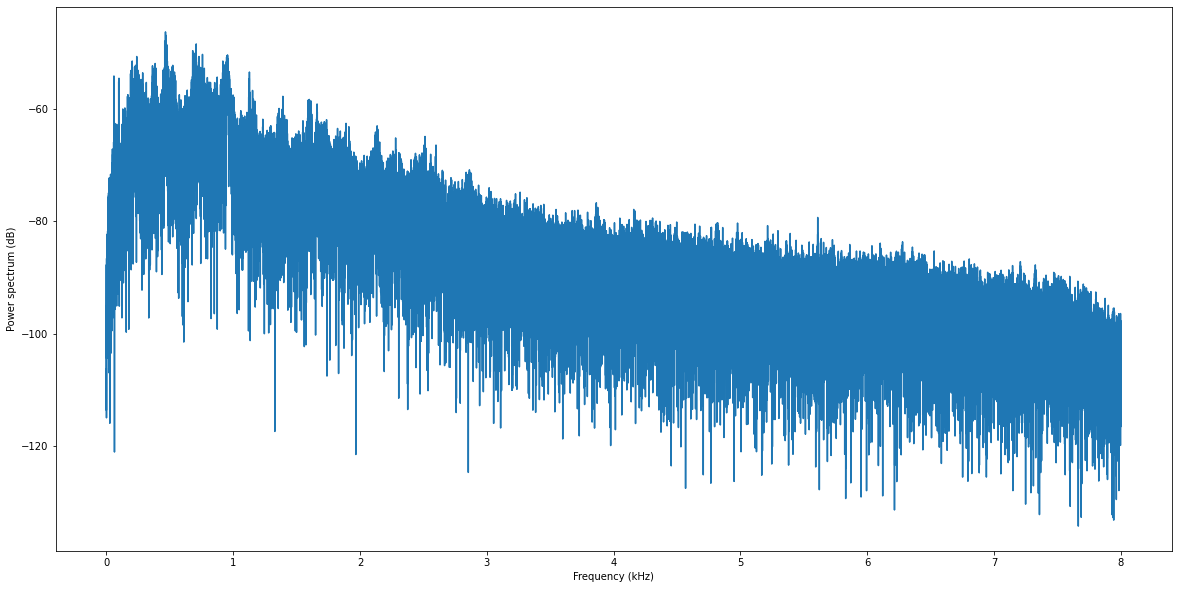

In [42]:
#@markdown Representação em frequência -> Espectro

def plot_spectrum(Audiodata):
  ''' Plota a representação do espectro de um arquivo de áudio
  peguei o código de:
  https://stackoverflow.com/questions/24382832/audio-spectrum-extraction-from-audio-file-by-python
  
  '''

  # spectrum
  n = len(Audiodata) 
  AudioFreq = fft(Audiodata)
  AudioFreq = AudioFreq[0:int(np.ceil((n+1)/2.0))] #Half of the spectrum
  MagFreq = np.abs(AudioFreq) # Magnitude
  MagFreq = MagFreq / float(n)
  # power spectrum
  MagFreq = MagFreq**2
  if n % 2 > 0: # ffte odd 
      MagFreq[1:len(MagFreq)] = MagFreq[1:len(MagFreq)] * 2
  else:# fft even
      MagFreq[1:len(MagFreq) -1] = MagFreq[1:len(MagFreq) - 1] * 2 

  plt.figure(figsize=(20,10))
  freqAxis = np.arange(0,int(np.ceil((n+1)/2.0)), 1.0) * (fs / n);
  plt.plot(freqAxis/1000.0, 10*np.log10(MagFreq)) #Power spectrum
  plt.xlabel('Frequency (kHz)'); plt.ylabel('Power spectrum (dB)');


plot_spectrum(normalized_s)
print('Observe que ha muitos componentes de frequencia acima de 3.4KHz(canal da voz)')


In [44]:
#@markdown Implementando um filtro Butterworth para a faixa de interesse.

#@markdown **Referencia** https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.butter.html


def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a


def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y




5 100 5000


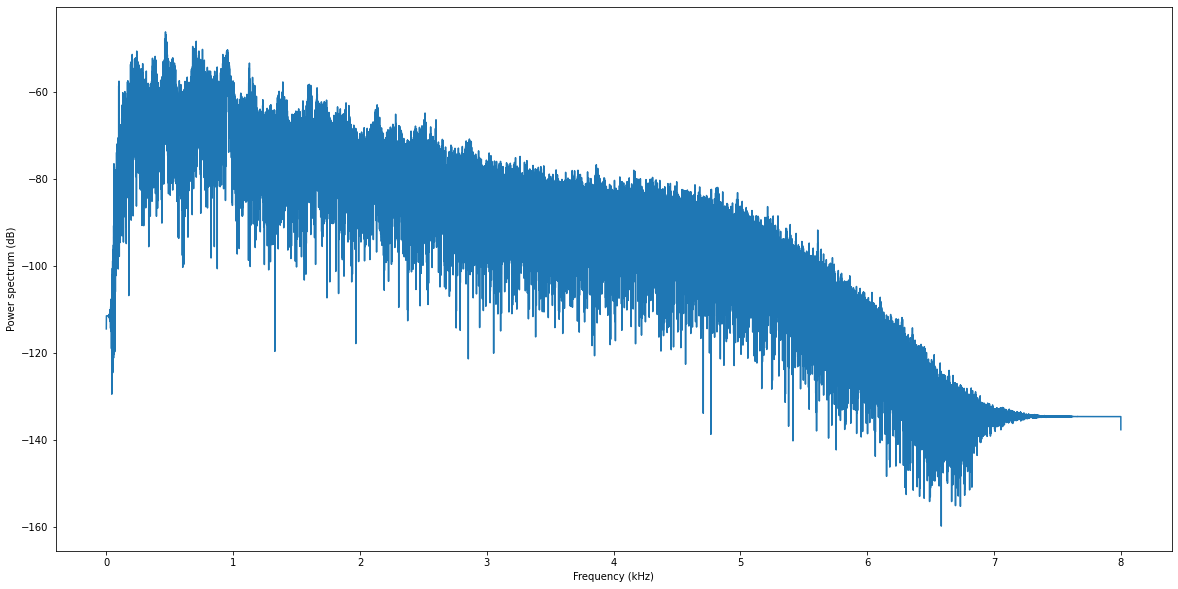

In [50]:
####@ title Teste de filtro ButterWorth. { run: "auto", vertical-output: true }
order = 5 #@param {type:"slider", min:1, max:15, step:1}
freq_inferior =100 #@param {type:"slider", min:0, max:1000, step:100}
freq_superior = 5000 #@param {type:"slider", min:1100, max:8000, step:100}
sample_rate = 16000
signal = butter_bandpass_filter(normalized_s, freq_inferior, freq_superior, 16000, order=order)
plot_spectrum(signal)
print(order, freq_inferior, freq_superior)

In [51]:
#@markdown Sinal sem os componentes de alta frequencia
plot_sinal(signal)

Output hidden; open in https://colab.research.google.com to view.

### Pipeline a ser seguido

* Ler o audio -> normalizar -> Filtrar -> Extrair

  * Normalizar: normalizar_audio()
  * Filtrar: butter_bandpass_filter(normalized_s, 400, 4000, 16000, order=order)
  * Extrair: TBD


In [ ]:
fs

In [52]:
#def mid_feature_extraction(signal, sampling_rate, mid_window, mid_step,
#                           short_window, short_step):

#mid_features, _, mid_feature_names = 

mt, st, mt_n = mTF.mid_feature_extraction(signal = signal,sampling_rate = fs,
                                          mid_window = len(s), 
                                          mid_step = len(s), 
                                          short_window = 0.05*fs,
                                          short_step =0.05*fs )

#@markdown len(s) = 16000 * 10s = 160000. Colocando mid_windown = mid_step = len(s)
#@markdown faz com que o audio todo seja representado por um unico conjunto de features,
#@markdown que é a media das shortterm features calculadas

#@markdown short_window = short_step = 0.05s / 10s = 200 short term features calculadas

#@markdown mt_n tem os nomes das features. Total de 136
#@markdown sãão elas:
print(mt_n)

['zcr_mean', 'energy_mean', 'energy_entropy_mean', 'spectral_centroid_mean', 'spectral_spread_mean', 'spectral_entropy_mean', 'spectral_flux_mean', 'spectral_rolloff_mean', 'mfcc_1_mean', 'mfcc_2_mean', 'mfcc_3_mean', 'mfcc_4_mean', 'mfcc_5_mean', 'mfcc_6_mean', 'mfcc_7_mean', 'mfcc_8_mean', 'mfcc_9_mean', 'mfcc_10_mean', 'mfcc_11_mean', 'mfcc_12_mean', 'mfcc_13_mean', 'chroma_1_mean', 'chroma_2_mean', 'chroma_3_mean', 'chroma_4_mean', 'chroma_5_mean', 'chroma_6_mean', 'chroma_7_mean', 'chroma_8_mean', 'chroma_9_mean', 'chroma_10_mean', 'chroma_11_mean', 'chroma_12_mean', 'chroma_std_mean', 'delta zcr_mean', 'delta energy_mean', 'delta energy_entropy_mean', 'delta spectral_centroid_mean', 'delta spectral_spread_mean', 'delta spectral_entropy_mean', 'delta spectral_flux_mean', 'delta spectral_rolloff_mean', 'delta mfcc_1_mean', 'delta mfcc_2_mean', 'delta mfcc_3_mean', 'delta mfcc_4_mean', 'delta mfcc_5_mean', 'delta mfcc_6_mean', 'delta mfcc_7_mean', 'delta mfcc_8_mean', 'delta mfcc_9_

In [14]:
#@title Operacionalizando o pipeline
#@markdown -----

In [53]:
freq_inferior = 100
freq_superior = 5000

features = [] 
feature_names = [] 
for file in tqdm(_HOMENS_FILES):
  # ler o arquivo
  _HOMENS_FILE = _HOMENS_DIR + file
  fs, s = aIO.read_audio_file(_HOMENS_FILE)
  # normalizar o audio
  normalized_s = normalizar_audio(s)
  # filter com o butterworth
  filtered_s = butter_bandpass_filter(normalized_s, freq_inferior, 
                                      freq_superior, fs, order=order)
  # extrair as features
  mt, st, mt_n = mTF.mid_feature_extraction(signal = filtered_s,
                                          sampling_rate = fs,
                                          mid_window = len(s), 
                                          mid_step = len(s), 
                                          short_window = 0.05*fs,
                                          short_step =0.05*fs )

  mt = np.append(mt,0) # Homem
  features.append(mt)
  # salvar em um lista

feature_names = mt_n
feature_names.append('Classe')

100%|██████████| 1000/1000 [19:18<00:00,  1.16s/it]


In [54]:
################# 
for file in tqdm(_MULHERES_FILES):
  # ler o arquivo
  _MULHERES_FILE = _MULHERES_DIR + file
  fs, s = aIO.read_audio_file(_MULHERES_FILE)
  # normalizar o audio
  normalized_s = normalizar_audio(s)
  # filter com o butterworth
  filtered_s = butter_bandpass_filter(normalized_s, freq_inferior, 
                                      freq_superior, fs, order=order)
  # extrair as features
  mt, st, mt_n = mTF.mid_feature_extraction(signal = filtered_s,
                                          sampling_rate = fs,
                                          mid_window = len(s), 
                                          mid_step = len(s), 
                                          short_window = 0.05*fs,
                                          short_step =0.05*fs )
  mt = np.append(mt, 1) # Mulher
  features.append(mt)


100%|██████████| 1000/1000 [19:04<00:00,  1.14s/it]


In [ ]:
### Criar Dataframe 
### -----

In [55]:
df = pd.DataFrame(data = features, columns = feature_names)
df.to_excel('Dataset_consolidadorev2.xlsx', index=False)
files.download('Dataset_consolidadorev2.xlsx')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Introdução
---



In [2]:
!pip install pyaudioanalysis tqdm eyed3 pydub tensorflow

In [3]:
#@title Import das bibliotecas
#@markdown ---
import pandas as pd
import numpy as np
import seaborn as sns
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
import pyAudioAnalysis
import IPython
import gc # garbage colector
import plotly.graph_objs as go 
import plotly
from google.colab import files

from scipy.signal import butter, lfilter
from scipy.fftpack import fft # fourier transform
from pyAudioAnalysis import audioBasicIO as aIO 
from pyAudioAnalysis import MidTermFeatures as mTF

from sklearn.metrics import confusion_matrix
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import SelectKBest
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
import sklearn.linear_model as skl_lm #LogisticRegression()

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

import plotly.express as px


__SEEDs__ = [1,2,3,4,5]
__FOLDS__ = 10

In [4]:
#@markdown Considerando o DATASET criado e armazenado no passo anterior, damos
#@markdown continuidade a analise.

#@markdown ----

from google.colab import drive
drive.flush_and_unmount
drive.mount('/content/drive', force_remount=True)

# Dados no Gdrive de Tiago
PATH_TIAGO = '/content/drive/My Drive/Aulas do Doutorado/Ciencia de dados/_Trabalho_final_Erico/_Dados/' 
os.chdir(PATH_TIAGO)
df = pd.read_excel('Dataset_consolidadorev2.xlsx')
df = df.sample(frac=1).reset_index(drop=True)
#df = pd.read_excel('Dataset_consolidado_sem_filtro.xlsx')

Mounted at /content/drive


In [5]:
df.dtypes.unique()

array([dtype('float64'), dtype('int64')], dtype=object)

In [6]:
df.tail()

,zcr_mean,energy_mean,energy_entropy_mean,spectral_centroid_mean,spectral_spread_mean,spectral_entropy_mean,spectral_flux_mean,spectral_rolloff_mean,mfcc_1_mean,mfcc_2_mean,mfcc_3_mean,mfcc_4_mean,mfcc_5_mean,mfcc_6_mean,mfcc_7_mean,mfcc_8_mean,mfcc_9_mean,mfcc_10_mean,mfcc_11_mean,mfcc_12_mean,mfcc_13_mean,chroma_1_mean,chroma_2_mean,chroma_3_mean,chroma_4_mean,chroma_5_mean,chroma_6_mean,chroma_7_mean,chroma_8_mean,chroma_9_mean,chroma_10_mean,chroma_11_mean,chroma_12_mean,chroma_std_mean,delta zcr_mean,delta energy_mean,delta energy_entropy_mean,delta spectral_centroid_mean,delta spectral_spread_mean,delta spectral_entropy_mean,...,chroma_9_std,chroma_10_std,chroma_11_std,chroma_12_std,chroma_std_std,delta zcr_std,delta energy_std,delta energy_entropy_std,delta spectral_centroid_std,delta spectral_spread_std,delta spectral_entropy_std,delta spectral_flux_std,delta spectral_rolloff_std,delta mfcc_1_std,delta mfcc_2_std,delta mfcc_3_std,delta mfcc_4_std,delta mfcc_5_std,delta mfcc_6_std,delta mfcc_7_std,delta mfcc_8_std,delta mfcc_9_std,delta mfcc_10_std,delta mfcc_11_std,delta mfcc_12_std,delta mfcc_13_std,delta chroma_1_std,delta chroma_2_std,delta chroma_3_std,delta chroma_4_std,delta chroma_5_std,delta chroma_6_std,delta chroma_7_std,delta chroma_8_std,delta chroma_9_std,delta chroma_10_std,delta chroma_11_std,delta chroma_12_std,delta chroma_std_std,Classe
1995,0.107378,0.019092,3.071622,0.184995,0.182579,0.904809,0.010741,0.180375,-25.559446,2.310687,-0.301538,0.070656,-0.085172,-0.012563,-0.073175,-0.126185,-0.059441,-0.106639,-0.081458,-0.074757,-0.133418,0.020886,0.004660,0.027288,0.018389,0.016213,0.011075,0.025638,0.004198,0.011953,0.025481,0.030132,0.005991,0.021856,0.000269,-0.000186,-0.000547,0.000151,0.000090,-0.000440,...,0.018152,0.027718,0.030007,0.011752,0.012908,0.062476,0.018559,0.472967,0.050559,0.034669,0.493880,0.009104,0.128441,1.402165,0.776396,0.616010,0.446476,0.363367,0.351979,0.283409,0.295213,0.288481,0.283164,0.331840,0.267777,0.293799,0.038092,0.010505,0.048666,0.023724,0.022995,0.015026,0.026184,0.008858,0.020961,0.027126,0.032008,0.016207,0.012126,1
1996,0.099362,0.006999,3.009439,0.178762,0.187208,0.682328,0.014636,0.143138,-27.408976,2.498478,-0.042886,0.001064,-0.008305,-0.091425,0.050437,0.102262,0.160407,0.048736,-0.029078,-0.058314,-0.236964,0.039101,0.014462,0.053916,0.010659,0.018497,0.008464,0.020704,0.002505,0.004774,0.010242,0.015053,0.018120,0.025183,-0.000275,0.000012,-0.003427,-0.000440,-0.000288,-0.003075,...,0.007455,0.016741,0.015498,0.029667,0.012733,0.069784,0.013455,0.398741,0.061216,0.034487,0.517141,0.012518,0.160038,1.554058,0.705395,0.584633,0.516818,0.408805,0.389082,0.347286,0.259373,0.285615,0.311432,0.334131,0.315658,0.337450,0.049099,0.026026,0.053234,0.023608,0.024427,0.017102,0.019443,0.006369,0.009735,0.021256,0.020556,0.033504,0.015188,1
1997,0.099243,0.030494,3.055010,0.172091,0.178977,0.677535,0.013847,0.158525,-26.487919,2.556131,0.344746,-0.374330,-0.202393,0.478563,-0.387162,0.319000,-0.101390,-0.264032,-0.506439,-0.351864,-0.190332,0.014745,0.009308,0.061111,0.036146,0.014498,0.010844,0.017762,0.000667,0.002357,0.022016,0.032273,0.003993,0.029808,-0.000294,-0.000127,0.001149,-0.000107,-0.000008,-0.002398,...,0.002870,0.026126,0.037857,0.005973,0.014558,0.058238,0.033658,0.357487,0.050421,0.033563,0.438115,0.012744,0.118639,1.879103,0.619464,0.599141,0.420813,0.427780,0.364868,0.358607,0.280007,0.295251,0.249641,0.247232,0.235075,0.236544,0.027418,0.019019,0.055888,0.049985,0.024217,0.029922,0.019296,0.001196,0.003332,0.032595,0.038351,0.007639,0.013796,0
1998,0.059268,0.023808,3.122315,0.125122,0.153046,0.443600,0.011394,0.080437,-24.766138,2.920998,-0.457143,0.194714,-0.260993,0.221452,-0.100583,-0.043406,-0.181681,-0.123976,-0.171550,-0.020891,-0.148332,0.026385,0.004781,0.021385,0.023900,0.020112,0.013193,0.019332,0.005746,0.008617,0.032599,0.036705,0.008977,0.021992,-0.000056,-0.000045,0.000203,0.000455,0.000567,0.001790,...,0.011901,0.028754,0.0331

In [7]:
df.shape

(2000, 137)

### São 136 features extraidas de cada áudio, sendo divididas em:
* 67 médias de features ao longo das janelas de curto prazo 
* 67 desvios-padrões calculados ao longo das janelas de curto prazo 

Estas sao as caracteristicas extraidas pelo *PyAudioAnalisys*. As features são extraidas em janelas de curta duraçao (Short Window), da ordem de milisegundos e podem ser representadas em pela media e desvio padrao de janelas de tempo maiores, determinadas Midterm Windows ou segmentos. Para termos apenas uma linha por audio, configuramos a midterm window igual ao tamanho dos áudios, que são de 10 segundos.

| Feature ID |    Feature Name    |                                                                         Description                                                                         |
|:----------:|:------------------:|:-----------------------------------------------------------------------------------------------------------------------------------------------------------:|
|      1     | Zero Crossing Rate |                                      The rate of sign-changes of the signal during the duration of a particular frame.                                      |
|      2     |       Energy       |                                     The sum of squares of the signal values, normalized by the respective frame length.                                     |
|      3     |  Entropy of Energy |                            The entropy of sub-frames' normalized energies. It can be interpreted as a measure of abrupt changes.                            |
|      4     |  Spectral Centroid |                                                            The center of gravity of the spectrum.                                                           |
|      5     |   Spectral Spread  |                                                          The second central moment of the spectrum.                                                         |
|      6     |  Spectral Entropy  |                                             Entropy of the normalized spectral energies for a set of sub-frames.                                            |
|      7     |    Spectral Flux   |                            The squared difference between the normalized magnitudes of the spectra of the two successive frames.                            |
|      8     |  Spectral Rolloff  |                                 The frequency below which 90% of the magnitude distribution of the spectrum is concentrated.                                |
|    9-21    |        MFCCs       |  Mel Frequency Cepstral Coefficients form a cepstral representation  where the frequency bands are not linear but distributed according to  the mel-scale.  |
|    22-33   |    Chroma Vector   | A 12-element representation of the spectral energy where the bins  represent the 12 equal-tempered pitch classes of western-type music  (semitone spacing). |
|     34     |  Chroma Deviation  |                                                    The standard deviation of the 12 chroma coefficients.                                                 |


* **Short-term feature extraction**: this is implemented in function feature_extraction() of the ShortTermFeatures.py file. It splits the input signal into short-term widnows (frames) and computes a number of features for each frame. This process leads to a sequence of short-term feature vectors for the whole signal.
* **Mid-term feature extraction**: In many cases, the signal is represented by statistics on the extracted short-term feature sequences described above. Towards this end, function mid_feature_extraction() from the MidTermFeatures.py file extracts a number of statistcs (e.g. mean and standard deviation) over each short-term feature sequence.

The total number of short-term features implemented in pyAudioAnalysis is 34. In addition, the delta features are optionally computed (they are by default enabled, but can be disabled by setting the deltas argument in feature_extraction() to false). So, the total number of short-term features, including the deltas is 64.


* Domínio Cepstral: é uma transformação logarítimca aplicada aos componentes do domínio da frequência, cuja idéia principal é representar os componentes do som dando importância maior aos que mais sensibilizam o ouvido humano. 

<center>
<img src="https://drive.google.com/uc?id=1WOoTJ8DvCJkrN8u4R7FzlYyWpHLSqQ7q" width="200"/>
</center>

## **Breve descritivo dos dados**
---------

In [8]:
#@markdown Observa-se que as variaveis estão em escalas diferentes, sendo necessário corrigir
#@markdown do standardScaler ou MinMax.
#@markdown A base é balanceada (criamos assim), com 1000 exemplos de vozes masculinas e 
#@markdown e 1000 de vozes femininas

df.describe()

,zcr_mean,energy_mean,energy_entropy_mean,spectral_centroid_mean,spectral_spread_mean,spectral_entropy_mean,spectral_flux_mean,spectral_rolloff_mean,mfcc_1_mean,mfcc_2_mean,mfcc_3_mean,mfcc_4_mean,mfcc_5_mean,mfcc_6_mean,mfcc_7_mean,mfcc_8_mean,mfcc_9_mean,mfcc_10_mean,mfcc_11_mean,mfcc_12_mean,mfcc_13_mean,chroma_1_mean,chroma_2_mean,chroma_3_mean,chroma_4_mean,chroma_5_mean,chroma_6_mean,chroma_7_mean,chroma_8_mean,chroma_9_mean,chroma_10_mean,chroma_11_mean,chroma_12_mean,chroma_std_mean,delta zcr_mean,delta energy_mean,delta energy_entropy_mean,delta spectral_centroid_mean,delta spectral_spread_mean,delta spectral_entropy_mean,...,chroma_9_std,chroma_10_std,chroma_11_std,chroma_12_std,chroma_std_std,delta zcr_std,delta energy_std,delta energy_entropy_std,delta spectral_centroid_std,delta spectral_spread_std,delta spectral_entropy_std,delta spectral_flux_std,delta spectral_rolloff_std,delta mfcc_1_std,delta mfcc_2_std,delta mfcc_3_std,delta mfcc_4_std,delta mfcc_5_std,delta mfcc_6_std,delta mfcc_7_std,delta mfcc_8_std,delta mfcc_9_std,delta mfcc_10_std,delta mfcc_11_std,delta mfcc_12_std,delta mfcc_13_std,delta chroma_1_std,delta chroma_2_std,delta chroma_3_std,delta chroma_4_std,delta chroma_5_std,delta chroma_6_std,delta chroma_7_std,delta chroma_8_std,delta chroma_9_std,delta chroma_10_std,delta chroma_11_std,delta chroma_12_std,delta chroma_std_std,Classe
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2.000000e+03,2.000000e+03,2000.000000,2000.000000,2000.000000,2000.000000,...,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,0.130743,0.018964,3.088742,0.199282,0.175395,1.078869,0.010909,0.208107,-26.125529,1.534166,-0.399085,-0.133467,-0.222082,0.039137,-0.139195,-0.098985,-0.103688,-0.077393,-0.092800,-0.047157,-0.083891,0.017803,0.007639,0.021010,0.016547,0.020631,0.014784,0.017677,0.005494,0.010278,0.015635,0.017538,0.008577,0.020118,2.203616e-06,4.783881e-06,0.000050,0.000022,0.000036,0.000061,...,0.016496,0.020325,0.021954,0.014436,0.011844,0.052493,0.018948,0.354992,0.042567,0.028245,0.436021,0.009075,0.107170,1.427424,0.648211,0.527711,0.422982,0.379149,0.340529,0.318088,0.301951,0.294718,0.288345,0.285484,0.278256,0.268938,0.026407,0.014836,0.027927,0.025991,0.027694,0.025361,0.024083,0.012975,0.018554,0.022242,0.023507,0.016412,0.012333,0.500000
std,0.042818,0.013998,0.088138,0.035327,0.012704,0.370795,0.003935,0.074500,2.279827,0.862917,0.530266,0.304649,0.239074,0.192655,0.177389,0.164516,0.138563,0.146887,0.127472,0.123503,0.113956,0.009456,0.003774,0.010869,0.008653,0.012340,0.007601,0.008746,0.002988,0.004533,0.007499,0.008868,0.003989,0.005839,5.206688e-04,1.775602e-04,0.002276,0.000404,0.000190,0.004075,...,0.007656,0.008379,0.009421,0.006964,0.002734,0.023940,0.008734,0.163431,0.018269,0.007541,0.127375,0.004623,0.042068,0.682011,0.206852,0.140394,0.098131,0.078590,0.059387,0.051152,0.046613,0.046136,0.046744,0.048416,0.046876,0.045351,0.011384,0.006638,0.011443,0.011354,0.011272,0.010647,0.009008,0.007269,0.007921,0.008232,0.009030,0.007303,0.002626,0.500125
min,0.039177,0.000629,2.682536,0.113641,0.123855,0.179584,0.002784,0.065165,-43.309312,-2.187713,-2.307597,-1.372421,-1.360549,-0.798985,-0.834553,-0.718942,-

## **Benchmark com o TensorFlow, considerando todas as features**
----

In [9]:
#@title Dividindo o DF em features (X) e um vetor com as classes (y)
#@markdown ---
X = df.iloc[:,:-1].astype(float)#.to_records()
y = df.iloc[:,-1:].values.ravel()

In [10]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                     test_size=0.20,
                                                     random_state=42)

In [11]:
import tensorflow as tf
from tensorflow import keras

model = tf.keras.models.Sequential([
  tf.keras.layers.InputLayer(input_shape=(136,)),
  tf.keras.layers.Dense(136, activation=tf.nn.relu),
  tf.keras.layers.Dense(10, activation=tf.nn.relu),
  tf.keras.layers.Dense(2, activation=tf.nn.softmax),
])
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.fit(X_train, y_train, epochs=200, verbose=False)

In [12]:
model.evaluate(X_test,y_test)
#@markdown Acurácia de 70% na base de teste (dados não vistos)

13/13 [==============================] - 0s 1ms/step - loss: 0.6109 - accuracy: 0.7275


[0.6109437942504883, 0.7275000214576721]

## **Seleção de variáveis**
----

In [13]:
#@title Dividindo o DF em features (X) e um vetor com as classes (y)
#@markdown ---
X = df.iloc[:,:-1].astype(float)#.to_records()
y = df.iloc[:,-1:].values.ravel()

In [14]:
#@title **Utilizando o ANOVA para seleção de variáveis.** 5 selecionadas.
#@markdown ---

scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.fit_transform(X)

n=5 # n is the number of features you want to keep
bestfeatures = SelectKBest(score_func=f_classif, k=n) 
fit = bestfeatures.fit(X_scaled,y) # x contains all the features and y contains target variable
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']
featuresNames = featureScores.nlargest(n,'Score').iloc[:,0]
featureScores.nlargest(n,'Score')


,Specs,Score
79,mfcc_4_std,163.113191
87,mfcc_12_std,145.787569
86,mfcc_11_std,135.457461
88,mfcc_13_std,130.606668
85,mfcc_10_std,126.346270


In [15]:
featuresNames_Classe = featuresNames
featuresNames_Classe[5] = 'Classe'
df_reduzido = df[featuresNames_Classe]


In [16]:
#@markdown * **Classe 0 - São vozes masculinas**
#@markdown * **Classe 1 são vozes femininas**
#@markdown * Verifica-se que essa feature tem um certa diferença para homens e mulheres
#@markdown porém sozinha não será capaz de discernir as duas classes.

fig = px.box(df_reduzido, x='Classe', y='mfcc_4_std')
fig.show()

* **Features consideradas:** mfcc_4_std, mfcc_12_std, mfcc_11_std, mfcc_13_std,mfcc_10_std

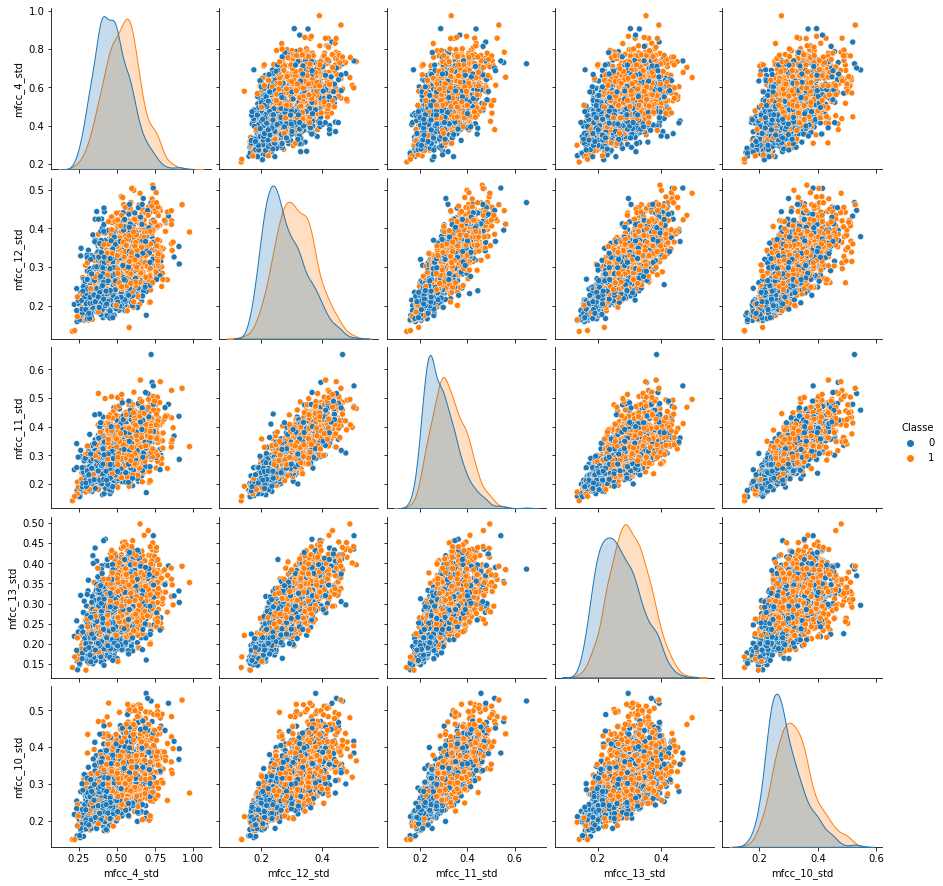

In [17]:
#@markdown Observa-se, principalmente dos histogramas, que as classes apresentam 
#@markdown distribuições ligeiramente diferentes e que não há uma variavel com 
#@markdown de discernir uma classe da outra isoladamente.
sns.pairplot(df_reduzido, hue="Classe")
#@markdown * Classe 0 - Homens
#@markdown * Classe 1 - Mulheres


## **Regressão Logística**
---
   - Apresentar a regressão logística simples para diferentes preditores
   - Sugestão de discussão: sinal do coeficiente de algum preditor mudou? Em caso afirmativo, apresente uma análise da motivação dessa modificação. Em caso negativo, análise o fato de poder remover algum dos preditores da regressão \múltipla e ainda continuar com um modelo aceitável.

- Individual: no mínimo 3 preditores
- Dupla: no mínimo 4 preditores
- Trio: no mínimo 5 preditores

In [18]:
#@title com uma variavel
import statsmodels.api as sm
# ravel Return a contiguous flattened array
#X_train = sm.add_constant(df.balance)

X = df_reduzido.iloc[:,:-1].astype(float) # 5 features mais importantes
y = df_reduzido.iloc[:,-1:].values.ravel()


X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                     test_size=0.20,
                                                     random_state=__SEEDs__[0])

est = sm.Logit(y_train.ravel(), X_train).fit()
est.summary2().tables[1]

#est.summary()

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



Optimization terminated successfully.
         Current function value: 0.687248
         Iterations 4


,Coef.,Std.Err.,z,P>|z|,[0.025,0.975]
mfcc_4_std,1.315173,0.488020,2.694916,0.007041,0.358671,2.271674
mfcc_12_std,0.997944,1.652360,0.603951,0.545876,-2.240622,4.236511
mfcc_11_std,1.598261,1.487739,1.074289,0.282693,-1.317653,4.514175
mfcc_13_std,-1.636155,1.349052,-1.212818,0.225199,-4.280249,1.007939
mfcc_10_std,-2.766623,1.220833,-2.266177,0.023441,-5.159412,-0.373835


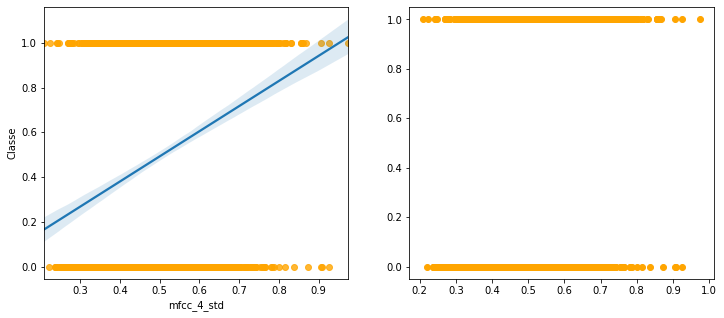

In [19]:
##markdown Apenas 1 preditor. mfcc_4_std
X_train = df_reduzido['mfcc_4_std'].values.reshape(-1,1) 
X_test =  np.arange(df_reduzido.mfcc_4_std.min(), df_reduzido.mfcc_4_std.max()).reshape(-1,1)
y_train = df_reduzido['Classe']
clf = skl_lm.LogisticRegression()
clf.fit(X_train,y_train)
prob = clf.predict_proba(X_test)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,5))

sns.regplot(x="mfcc_4_std", y="Classe", data=df_reduzido, ax=ax1, scatter_kws={'color':'orange'})

ax2.scatter(X_train, y_train, color='orange')
ax2.plot(X_test, prob[:,1])


In [20]:
prob

array([[0.77526456, 0.22473544]])

In [21]:
df_reduzido['mfcc_4_std'].dtype


dtype('float64')

# **Divisão dos dados em Treinamento e Teste**
----

## **Regressão Logística com 5 variáveis**
------

  * Apresentar a regressão logística simples para diferentes preditores
  * Sugestão de discussão: sinal do coeficiente de algum preditor mudou? Em caso afirmativo, apresente uma análise da motivação dessa modificação. Em caso negativo, análise o fato de poder remover algum dos preditores da regressão \múltipla e ainda continuar com um modelo aceitável.

  * Individual: no mínimo 3 preditores
  * Dupla: no mínimo 4 preditores
  * **Trio: no mínimo 5 preditores**

   Justifique os preditores selecionados para iniciar a regressão logística 

In [22]:
#@markdown Abaixo, criamos 5 modelos, adicionando uma feature de cada vez na 
#@markdown regressão logistica. 
#@markdown observa-se que o desempenho foi ligeiramente inferior ao da rede neural
#@markdown (proximo a 70% de acurácia) x 72% da rede neural.

X = df_reduzido.iloc[:,:-1].astype(float) # 5 features mais importantes
y = df_reduzido.iloc[:,-1:].values.ravel()


X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                     test_size=0.20,
                                                     random_state=__SEEDs__[0])
scores= []
features = ['mfcc_4_std', 'mfcc_12_std', 'mfcc_11_std', 'mfcc_13_std','mfcc_10_std']

for i,feature in enumerate(features):
  print('Features consideradas: ',features[:i+1])
  scalar = StandardScaler()
  LR = LogisticRegression(random_state=__SEEDs__[0])
  pipeline = Pipeline([('transformer', scalar), ('estimator', LR)])
  skf = StratifiedKFold(n_splits=__FOLDS__)
  scores_roc_auc = cross_val_score(pipeline, X[features[:i+1]], y, cv=skf, scoring='roc_auc').round(3)
  #scores_acc = cross_val_score(pipeline, X, y, cv = skf, scoring = 'accuracy')
  scores.append(scores_roc_auc)

Features consideradas:  ['mfcc_4_std']
Features consideradas:  ['mfcc_4_std', 'mfcc_12_std']
Features consideradas:  ['mfcc_4_std', 'mfcc_12_std', 'mfcc_11_std']
Features consideradas:  ['mfcc_4_std', 'mfcc_12_std', 'mfcc_11_std', 'mfcc_13_std']
Features consideradas:  ['mfcc_4_std', 'mfcc_12_std', 'mfcc_11_std', 'mfcc_13_std', 'mfcc_10_std']


In [23]:
scores

[array([0.673, 0.577, 0.632, 0.663, 0.693, 0.668, 0.658, 0.683, 0.664,
        0.721]),
 array([0.688, 0.596, 0.65 , 0.688, 0.722, 0.692, 0.704, 0.688, 0.679,
        0.73 ]),
 array([0.692, 0.591, 0.657, 0.69 , 0.715, 0.695, 0.703, 0.69 , 0.68 ,
        0.732]),
 array([0.693, 0.597, 0.648, 0.692, 0.704, 0.692, 0.705, 0.696, 0.669,
        0.738]),
 array([0.701, 0.601, 0.648, 0.687, 0.704, 0.694, 0.707, 0.702, 0.67 ,
        0.742])]

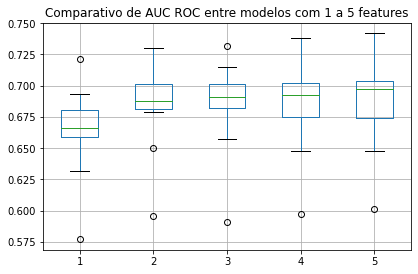

In [24]:
fig = plt.figure(figsize=(7,5))
ax1 = fig.add_subplot(1,1,1)
pd.DataFrame(scores).transpose().boxplot(grid=True, ax=ax1)
ax1.set_title('Comparativo de AUC ROC entre modelos com 1 a 5 features')
ax1.set_xticklabels([1,2,3,4,5],rotation=0)
fig.tight_layout(pad=5.0)
plt.show()


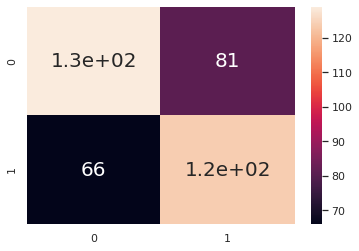

In [25]:
#@markdown Acuracia de 67% utilizando 5 preditores e medido na fração reservada para teste
from sklearn.metrics import confusion_matrix

# Visual libraries
import seaborn as sns
pipeline.fit(X_train,y_train)

y_pred = pipeline.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

df_cm = pd.DataFrame(cm, range(2),range(2))
sns.set(font_scale=1)
sns.heatmap(df_cm, annot=True,annot_kws={"size": 20})

## **KNN**
---
- Apresentar K-NN para diferentes combinações entre métrica e número de vizinhos

- Sugestão de discussão: a influência do número de vizinhos é significativa? a métrica influencia os resultados?


In [26]:
#@markdown Selecionando 7 variáveis mais importantes com o ANOVA
X = df.iloc[:,:-1].astype(float)#.to_records()
y = df.iloc[:,-1:].values.ravel()


scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.fit_transform(X)

n=7 # n is the number of features you want to keep
bestfeatures = SelectKBest(score_func=f_classif, k=n) 
fit = bestfeatures.fit(X_scaled,y) # x contains all the features and y contains target variable
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']
featuresNames = featureScores.nlargest(n,'Score').iloc[:,0]
featureScores.nlargest(n,'Score')

,Specs,Score
79,mfcc_4_std,163.113191
87,mfcc_12_std,145.787569
86,mfcc_11_std,135.457461
88,mfcc_13_std,130.606668
85,mfcc_10_std,126.346270
122,delta mfcc_13_std,91.664057
121,delta mfcc_12_std,87.096958


In [27]:
#@markdown 7 Features selecionadas
features_knn= ['mfcc_4_std', 'mfcc_12_std', 'mfcc_11_std', 
               'mfcc_13_std', 'mfcc_10_std',  'delta mfcc_13_std',
               'delta mfcc_12_std']

featuresNames_Classe = features_knn
featuresNames_Classe.append('Classe')
df_reduzido = df[featuresNames_Classe]

X = df_reduzido.iloc[:,:-1].astype(float)#.to_records()
y = df_reduzido.iloc[:,-1:].values.ravel()



In [28]:
#@ Divisão entre treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                     test_size=0.20,
                                                     random_state=__SEEDs__[0])

scaler = StandardScaler()
scaler.fit(X_train)
X_scaled = scaler.fit_transform(X_train)

In [29]:
##@title Realizando um GridSearch com diversos parametros para buscar os valores otimos.

from sklearn.model_selection import GridSearchCV

n_values = [4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25]
metric_values =['minkowski', 'euclidean', 'manhattan']
weights_values = ['uniform', 'distance']
algorithm_values = ['ball_tree','kd_tree','brute']

param_grid = dict(n_neighbors = n_values, metric= metric_values,
                  weights=weights_values, algorithm = algorithm_values)

model_KNN = KNeighborsClassifier()
kfold = KFold(n_splits=__FOLDS__, random_state=__SEEDs__[0], shuffle=True)
grid = GridSearchCV(estimator=model_KNN, param_grid=param_grid,
                    scoring='roc_auc', cv=kfold, verbose=0)

grid_result = grid.fit(X_scaled, y_train)

In [30]:
#@markdown A o melhor valor (0.697) da AUC_ROC obtido foi com os parametros
#@markdown - Algoritimo: Ball_tree
#@markdown - metrica: Manhattan
#@markdown - n_neighbors: 16
#@markdown - weights: uniform 

print("Melhor valor: %f parametros utilizados %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_[ 'mean_test_score' ]
stds = grid_result.cv_results_[ 'std_test_score' ]
params = grid_result.cv_results_[ 'params' ]
I = 10 # melhores i combinacoes
i=0
print('Outros modelos..')
for mean, stdev, param in zip(means, stds, params):
    i=i+1
    print("%f (%f) with: %r" % (mean, stdev, param))
    if i>I:
      break     




Melhor valor: 0.679528 parametros utilizados {'algorithm': 'ball_tree', 'metric': 'manhattan', 'n_neighbors': 23, 'weights': 'uniform'}
Outros modelos..
0.627467 (0.036320) with: {'algorithm': 'ball_tree', 'metric': 'minkowski', 'n_neighbors': 4, 'weights': 'uniform'}
0.572824 (0.040041) with: {'algorithm': 'ball_tree', 'metric': 'minkowski', 'n_neighbors': 4, 'weights': 'distance'}
0.640853 (0.038441) with: {'algorithm': 'ball_tree', 'metric': 'minkowski', 'n_neighbors': 5, 'weights': 'uniform'}
0.576653 (0.037533) with: {'algorithm': 'ball_tree', 'metric': 'minkowski', 'n_neighbors': 5, 'weights': 'distance'}
0.643065 (0.037879) with: {'algorithm': 'ball_tree', 'metric': 'minkowski', 'n_neighbors': 6, 'weights': 'uniform'}
0.572676 (0.037079) with: {'algorithm': 'ball_tree', 'metric': 'minkowski', 'n_neighbors': 6, 'weights': 'distance'}
0.643859 (0.041247) with: {'algorithm': 'ball_tree', 'metric': 'minkowski', 'n_neighbors': 7, 'weights': 'uniform'}
0.570684 (0.040892) with: {'algo

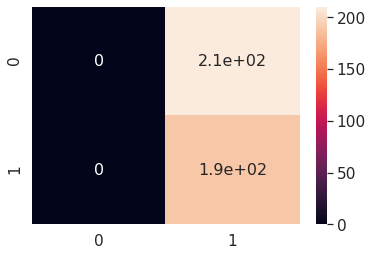

In [31]:
#@markdown Valores preditos
#@markdown apresentou desempenho abaixo da regressão logistica
#@markdown errando bastante a classe 0 (homens)
y_pred = grid_result.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, range(2),range(2))
sns.set(font_scale=1.4)
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16})

## **Árvore de decisão**
-------------

In [32]:
#@markdown Com 7 Features selecionadas
X = df_reduzido.iloc[:,:-1].astype(float)#.to_records()
y = df_reduzido.iloc[:,-1:].values.ravel()

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                          test_size=0.20,
                                          random_state=__SEEDs__[0])
scaler = StandardScaler()
scaler.fit(X_train)
X_scaled = scaler.fit_transform(X_train)
features_dt= ['mfcc_4_std', 'mfcc_12_std', 'mfcc_11_std', 
               'mfcc_13_std', 'mfcc_10_std','delta mfcc_13_std',
               'delta mfcc_12_std']


In [34]:
#@markdown Realizando um GridSearch com o os valores
#@markdown de Max_depth, Max_leaf_nodes e Max_features
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

max_depth_values = [None,1,2,3,4,5,6,7,8,9,10]
max_leaf_nodes_values =[2,3,4,5,6,7,8,9,10]
max_features_values = [1,2,3,4,5,6,7]

param_grid = dict(max_depth = max_depth_values, 
                max_leaf_nodes= max_leaf_nodes_values,
                max_features=max_features_values)

model = DecisionTreeClassifier()
kfold = KFold(n_splits=__FOLDS__, random_state=__SEEDs__[0], shuffle=True)
grid = GridSearchCV(estimator=model, param_grid=param_grid,
                    scoring='roc_auc', cv=kfold, verbose=0)

grid_result = grid.fit(X_scaled, y_train)

In [35]:
##@markdown A o melhor valor (0.68) da AUC_ROC obtido foi com os parametros
##@markdown - Max_depth = 5
##@markdown - Max_features = 4
##@markdown - Max_leaf_nodes = 9

print("Melhor valor: %f parametros utilizados %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_[ 'mean_test_score' ]
stds = grid_result.cv_results_[ 'std_test_score' ]
params = grid_result.cv_results_[ 'params' ]
I = 10 # melhores i combinacoes
i=0
print('Outros modelos..')
for mean, stdev, param in zip(means, stds, params):
    i=i+1
    print("%f (%f) with: %r" % (mean, stdev, param))
    if i>I:
      break     


Melhor valor: 0.680133 parametros utilizados {'max_depth': 5, 'max_features': 4, 'max_leaf_nodes': 9}
Outros modelos..
0.595869 (0.038925) with: {'max_depth': None, 'max_features': 1, 'max_leaf_nodes': 2}
0.618981 (0.035598) with: {'max_depth': None, 'max_features': 1, 'max_leaf_nodes': 3}
0.634506 (0.043271) with: {'max_depth': None, 'max_features': 1, 'max_leaf_nodes': 4}
0.640592 (0.037819) with: {'max_depth': None, 'max_features': 1, 'max_leaf_nodes': 5}
0.649068 (0.032432) with: {'max_depth': None, 'max_features': 1, 'max_leaf_nodes': 6}
0.653808 (0.042416) with: {'max_depth': None, 'max_features': 1, 'max_leaf_nodes': 7}
0.655762 (0.052991) with: {'max_depth': None, 'max_features': 1, 'max_leaf_nodes': 8}
0.649606 (0.045465) with: {'max_depth': None, 'max_features': 1, 'max_leaf_nodes': 9}
0.660099 (0.042381) with: {'max_depth': None, 'max_features': 1, 'max_leaf_nodes': 10}
0.622668 (0.022468) with: {'max_depth': None, 'max_features': 2, 'max_leaf_nodes': 2}
0.645586 (0.036305) 

In [36]:
##@markdown Treinando o modelo com os parametros acima por meio de um **pipeline**

scores= []
scalar = StandardScaler()
model = DecisionTreeClassifier(max_depth=3, max_features=4, max_leaf_nodes=9)
pipeline = Pipeline([('transformer', scalar), ('estimator', model)])
skf = StratifiedKFold(n_splits=__FOLDS__)
scores_roc_auc = cross_val_score(pipeline, X_train, y_train, cv=skf, scoring='roc_auc').round(3)
#scores_acc = cross_val_score(pipeline, X, y, cv = skf, scoring = 'accuracy')
scores.append(scores_roc_auc)
print(scores)

[array([0.673, 0.627, 0.633, 0.643, 0.613, 0.647, 0.663, 0.702, 0.756,
       0.656])]


In [37]:
#@markdown Valores preditos
#@markdown apresentou desempenho abaixo da regressão logistica
#@markdown errando bastante a classe 1 (mulheres)
#@markdown acurácia de 67%

scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)
DT = DecisionTreeClassifier(max_depth=3,
                               max_features=4,
                               max_leaf_nodes=9)

Model = DT.fit(X_train_scaled,y_train)

y_pred = DT.predict(X_test_scaled)
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, range(2),range(2))
sns.set(font_scale=1.4)
#sns.heatmap(df_cm, annot=True,annot_kws={"size": 16})

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning:

The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).



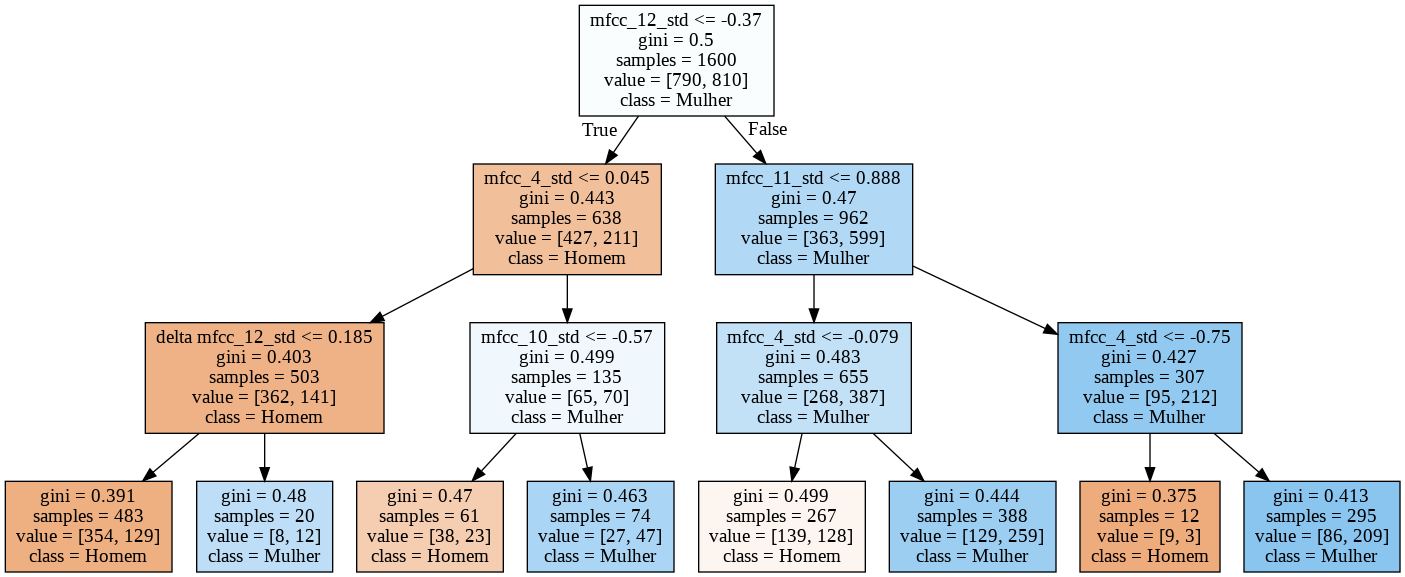

In [38]:
#@markdown A Feature decisiva passou a ser o **mfcc_12_std**
#@markdown Porem o desempenho ficou abaixo de 70% (acuracia)

from sklearn.tree import export_graphviz
from sklearn.externals.six import StringIO
import pydot
from IPython.display import Image

dot_data = StringIO()

export_graphviz(Model, out_file=dot_data, feature_names=X_test.columns, class_names=['Homem', 'Mulher'], filled=True)
graph, = pydot.graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())

## **Floresta aleatoria**
---------

   - Apresentar florestas aleatórias para diferentes combinações entre profundidade, número máximo de folhas, número de árvores e número de preditores
   - Faça análise do “out of bag error”
   - Sugestão de discussão: qual a influência nos resultados quanto a número de preditores?

In [39]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

In [40]:
len(X_train_scaled)

1600

In [57]:
##@markdown Realizando um GridSearch com o os valores
##@markdown de Max_depth, Max_leaf_nodes e Max_features, e n_estimators

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

max_depth_values = [None,4,6,10]
max_leaf_nodes_values =[2,6,10]
max_features_values = [2,5,7]
n_estimator_values = [ 50, 100, 200]
#max_samples_values = [400,800,1400] #1600 é o total de amostras no X_train

param_grid = dict(max_depth = max_depth_values, 
                max_leaf_nodes= max_leaf_nodes_values,
                max_features=max_features_values,
                n_estimators = n_estimator_values,
#                max_samples = max_samples_values
                )

model = RandomForestClassifier(oob_score = True,verbose=0)
kfold = KFold(n_splits=__FOLDS__, random_state=__SEEDs__[0], shuffle=True)
grid = GridSearchCV(estimator=model, param_grid=param_grid,
                    scoring='roc_auc', cv=kfold, verbose=0)

grid_result = grid.fit(X_train_scaled, y_train)

In [46]:
print('Melhores parametros encontrados: ', grid_result.best_params_)
print('Melhor escore: ', grid_result.best_score_.round(3))
print('Melhor modelo: ', grid_result.best_estimator_)

#@markdown Essa Arvore aleatória com:
#@markdown * Max_depth = 6
#@markdown * max_features = 5
#@markdown * max_leaf_nodes = 6
#@markdown * n_estimators = 5

#@markdown apresentou um desempenho proximo ao bechmark (TensorFlow)
#@markdown com acuraciade 69%

Melhores parametros encontrados:  {'max_depth': 6, 'max_features': 5, 'max_leaf_nodes': 6, 'n_estimators': 50}
Melhor escore:  0.698
Melhor modelo:  RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=6, max_features=5,
                       max_leaf_nodes=6, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=True, random_state=None,
                       verbose=0, warm_start=False)


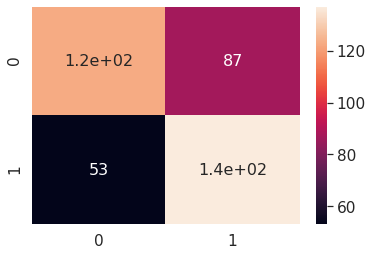

In [54]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)
RF = RandomForestClassifier(max_depth=6,
                            max_features=5,
                            max_leaf_nodes=6,
                            n_estimators = 50, 
                            oob_score=True)

Model = RF.fit(X_train_scaled,y_train)

y_pred = RF.predict(X_test_scaled)
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, range(2),range(2))
sns.set(font_scale=1.4)
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16})

In [56]:
RF.oob_score_

#@markdown o Out of Bag Score foi de 0.658 que foi 
#@markdown similar ao valor da acuracia quando avaliada na base de teste


0.65875

## **LDA**
----
   - Apresentar LDA para diferentes threshold
   - Sugestão de discussão: há uma melhora com a variação do threshold?


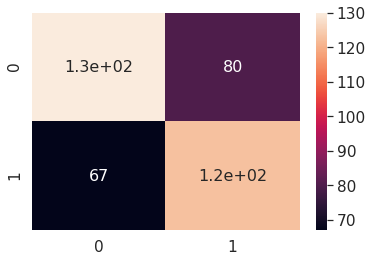

In [61]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import GridSearchCV

scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

LDA = LinearDiscriminantAnalysis()
Model = LDA.fit(X_train_scaled,y_train)

y_pred = Model.predict(X_test_scaled)
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, range(2),range(2))
sns.set(font_scale=1.4)
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16})

In [86]:
#@markdown O liminar de decisão cai em uma faixa bastante estreita
#@markdown entre 0.1 e 0.65, onde se o valor for 0.1 todos os valores
#@markdown preditos são de voz masculina; Ja se for 0.9, todos os valores
#@markdown preditos são de vozes femininas.
#@markdown o valor de 0.5 se mostrou o melhor valor.
#@markdown * Acuracia = 63.25%
decision_prob = 0.5
y_prob = Model.fit(X_train_scaled, y_train).predict_proba(X_test_scaled)

df_ = pd.DataFrame({'True default status': y_test,
                    'Predicted default status': y_prob[:,1] > decision_prob})
df_.replace(to_replace={0:'Mulher', 1:'Homem', 'True':'Yes', 'False':'No'}, inplace=True)

df_.groupby(['Predicted default status','True default status']).size().unstack('True default status')

True default status,Homem,Mulher
Predicted default status,,
Homem,123,80
Mulher,67,130


In [94]:
#@markdown O liminar de decisão cai em uma faixa bastante estreita
#@markdown entre 0.1 e 0.65, onde se o valor for 0.1 todos os valores
#@markdown preditos são de voz masculina; Ja se for 0.9, todos os valores
#@markdown preditos são de vozes femininas.
#@markdown o valor de 0.5 se mostrou o melhor valor.
#@markdown * Acuracia = 51.50%
decision_prob = 0.3
y_prob = Model.fit(X_train_scaled, y_train).predict_proba(X_test_scaled)

df_ = pd.DataFrame({'True default status': y_test,
                    'Predicted default status': y_prob[:,1] > decision_prob})
df_.replace(to_replace={0:'Mulher', 1:'Homem', 'True':'Yes', 'False':'No'}, inplace=True)

df_.groupby(['Predicted default status','True default status']).size().unstack('True default status')

True default status,Homem,Mulher
Predicted default status,,
Homem,180,184
Mulher,10,26


In [95]:
#@markdown O liminar de decisão cai em uma faixa bastante estreita
#@markdown entre 0.1 e 0.65, onde se o valor for 0.1 todos os valores
#@markdown preditos são de voz masculina; Ja se for 0.9, todos os valores
#@markdown preditos são de vozes femininas.
#@markdown o valor de 0.5 se mostrou o melhor valor.
#@markdown * Acuracia = 57.25%
decision_prob = 0.7
y_prob = Model.fit(X_train_scaled, y_train).predict_proba(X_test_scaled)

df_ = pd.DataFrame({'True default status': y_test,
                    'Predicted default status': y_prob[:,1] > decision_prob})
df_.replace(to_replace={0:'Mulher', 1:'Homem', 'True':'Yes', 'False':'No'}, inplace=True)

df_.groupby(['Predicted default status','True default status']).size().unstack('True default status')

True default status,Homem,Mulher
Predicted default status,,
Homem,34,15
Mulher,156,195


In [96]:
#@markdown O liminar de decisão cai em uma faixa bastante estreita
#@markdown entre 0.1 e 0.65, onde se o valor for 0.1 todos os valores
#@markdown preditos são de voz masculina; Ja se for 0.9, todos os valores
#@markdown preditos são de vozes femininas.
#@markdown o valor de 0.5 se mostrou o melhor valor.
#@markdown * Acuracia = 52.75%

decision_prob = 0.8
y_prob = Model.fit(X_train_scaled, y_train).predict_proba(X_test_scaled)

df_ = pd.DataFrame({'True default status': y_test,
                    'Predicted default status': y_prob[:,1] > decision_prob})
df_.replace(to_replace={0:'Mulher', 1:'Homem', 'True':'Yes', 'False':'No'}, inplace=True)

df_.groupby(['Predicted default status','True default status']).size().unstack('True default status')

True default status,Homem,Mulher
Predicted default status,,
Homem,8,7
Mulher,182,203


## **SVM**
----
   - Apresentar SVM para diferentes combinações de kernels, C e Gamma
   - Sugestão de discussão: qual a influência nos resultados quanto aos kenels, C e Gamma

In [92]:

from sklearn.svm import SVC

kernel_values = ['linear', 'poly', 'rbf', 'sigmoid']
C_values =[0.1,1,]
Gamma_values = [1,0.2,0.1]


param_grid = dict(kernel = kernel_values, 
                C = C_values,
                gamma = Gamma_values
                )

model = SVC(verbose=0)
kfold = KFold(n_splits=__FOLDS__, random_state=__SEEDs__[0], shuffle=True)
grid = GridSearchCV(estimator=model, param_grid=param_grid,
                    scoring='roc_auc', cv=kfold, verbose=0)

grid_result = grid.fit(X_train_scaled, y_train)

In [93]:
#@markdown O desempenho obtido foi equivalente ao TensorFlow, com acurácia de 0.70
#@markdown Os melhores parametros encontrados foram:
#@markdown * C = 1
#@markdown * kernel = 'rbf' (curva fechada)
#@markdown * gamma = 0.1
print('Melhores parametros encontrados: ', grid_result.best_params_)
print('Melhor escore: ', grid_result.best_score_.round(3))
print('Melhor modelo: ', grid_result.best_estimator_)


Melhores parametros encontrados:  {'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}
Melhor escore:  0.704
Melhor modelo:  SVC(C=1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=0)


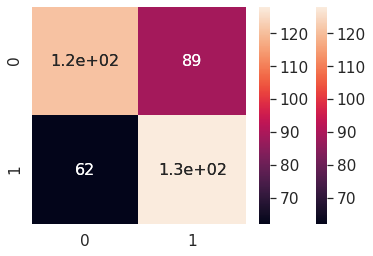

In [97]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

SVM = SVC(C =1, kernel='rbf', gamma=0.1)
Model =  SVM.fit(X_train_scaled,y_train)

y_pred = Model.predict(X_test_scaled)
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, range(2),range(2))
sns.set(font_scale=1.4)
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16})

y_pred = grid.predict(X_test_scaled)
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, range(2),range(2))
sns.set(font_scale=1.4)
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16})

## **Resultados e Discussão**
---
### Resultados obtidos

Os modelos de classificação de voz masculina ou feminina apresentam acurácias superiores à 98% porém com outro conjunto de features. O que realizamos aqui foi converter cada audio de 10s em um conjunto de 136 features representativas desses 10s de audio utilizando o pyAudioAnalysis. Observou-se que o intervalo de tempo (10s) foi bastante alto para se extrair as features. Melhor seria utilizar as janelas menores ou outras features. Com as que utilizamos neste trabalho, o valor maximo de acurácia obtido foi de 72%.
 


Algoritimo | acuracia 
-------------------|------------------
Tensorflow (DNN)   | **72.75%**
LDA                | 63.25%
Floresta aleatoria | 69.80%
Arvore de decisão  | 67.30%
KNN                | 69.70%
Reg. Logistica     | 63.25%
SVM                | 62.25%






#### Avaliando se o melhor (Floresta aleatória) e o pior modelo (Reg. logistica) apresentam, de fato, uma diferença de performance estatisticamente significativa (TBD)
----


In [100]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error

# target = auto.horsepower
# del auto["horsepower"]
# del auto["name"]
reg1 = RandomForestClassifier(max_depth=6,
                            max_features=5,
                            max_leaf_nodes=6,
                            n_estimators = 50, 
                            oob_score=True)

reg2 = LogisticRegression()

target = df_reduzido
# Choose seeds for each 2-fold iterations
seeds = [13, 51, 137, 24659, 347]

# Initialize the score difference for the 1st fold of the 1st iteration 
p_1_1 = 0.0

# Initialize a place holder for the variance estimate
s_sqr = 0.0

# Initialize scores list for both classifiers
scores_1 = []
scores_2 = []
diff_scores = []

# Iterate through 5 2-fold CV
for i_s, seed in enumerate(seeds):

    # Split the dataset in 2 parts with the current seed
    folds = KFold(n_splits=2, shuffle=True, random_state=seed)

    # Initialize score differences
    p_i = np.zeros(2)

    # Go through the current 2 fold
    for i_f, (trn_idx, val_idx) in enumerate(folds.split(target, target)):

        # Split the data
        trn_x, trn_y = df_reduzido.iloc[trn_idx], target.iloc[trn_idx]
        val_x, val_y = df_reduzido.iloc[val_idx], target.iloc[val_idx]

        # Train regression
        reg1.fit(trn_x, trn_y)
        reg2.fit(trn_x, trn_y)

        # Compute scores
        preds_1 = reg1.predict(val_x)
        score_1 = mean_squared_error(val_y, preds_1)
        preds_2 = reg2.predict(val_x)
        score_2 = mean_squared_error(val_y, preds_2)

        # keep score history for mean and stdev calculation
        scores_1.append(score_1)
        scores_2.append(score_2)
        diff_scores.append(score_1 - score_2)
        print("Fold %2d score difference = %.6f" % (i_f + 1, score_1 - score_2))

        # Compute score difference for current fold  
        p_i[i_f] = score_1 - score_2

        # Keep the score difference of the 1st iteration and 1st fold
        if (i_s == 0) & (i_f == 0):
            p_1_1 = p_i[i_f]

    # Compute mean of scores difference for the current 2-fold CV
    p_i_bar = (p_i[0] + p_i[1]) / 2

    # Compute the variance estimate for the current 2-fold CV
    s_i_sqr = (p_i[0] - p_i_bar) ** 2 + (p_i[1] - p_i_bar) ** 2 

    # Add up to the overall variance
    s_sqr += s_i_sqr
    
# Compute t value as the first difference divided by the square root of variance estimate
t_bar = p_1_1 / ((s_sqr / 5) ** .5) 

print("Regression 1 mean score and stdev : %.6f + %.6f" % (np.mean(scores_1), np.std(scores_1)))
print("Regression 2 mean score and stdev : %.6f + %.6f" % (np.mean(scores_2), np.std(scores_2)))
print("Score difference mean + stdev : %.6f + %.6f" 
      % (np.mean(diff_scores), np.std(diff_scores)))
print("t_value for the current test is %.6f" % t_bar)

ValueError: ignored

## Dificuldades e Desafios
---
- Maiores dificuldades foram, e ainda são, com os conceitos de estatística que ainda precisam ser aprofundados. 
- **Não foi possivel implementar o teste de McNemar para avaliar se, de fato, um modelo de ML tem desempenho melhor que outro. Iremos revisar a teoria a respeito.**


## **Referência**
---

1. **AudioSet**: Jort F. Gemmeke Daniel P. W. Ellis Dylan Freedman Aren Jansen Wade Lawrence R. Channing Moore Manoj Plakal Marvin Ritter Proc. IEEE ICASSP 2017, New Orleans, LA (to appear) **Audio Set**: An ontology and human-labeled dataset for audio events (https://research.google.com/audioset/) 

2. **AudioSet Processing**: https://github.com/aoifemcdonagh/audioset-processing

3. **SoX - Sound eXchange** http://sox.sourceforge.net

4. **Facts about Speech**: https://www.dpamicrophones.com/mic-university/facts-about-speech-intelligibility

4. T. G. Dietterich, “Approximate Statistical Tests for Comparing Supervised Classification Learning Algorithms”, Neural Computation, vol. 10, nº 7, p. 1895–1923, out. 1998, doi: 10.1162/089976698300017197. - Sobre como comparar o desempenho de modelos de ML de forma correta.

5. http://mathcenter.oxford.emory.edu/site/math117/parametricVsNonparametric/ - Diferença entre testes parametricos e não-paramétricos

6. https://towardsdatascience.com/what-is-out-of-bag-oob-score-in-random-forest-a7fa23d710 - Sobre o Out Of Bag Score do Random Forrest

7.  https://en.wikipedia.org/wiki/Voice_frequency#Fundamental_frequency - Sobre a voz humana.

8.  https://medium.com/analytics-vidhya/how-to-filter-noise-with-a-low-pass-filter-python-885223e5e9b7 - Como construir um filtro passa faixa em python.

9 https://machinelearningmastery.com/mcnemars-test-for-machine-learning/ - Como comparar dois modelos de ML.


## **Estratégia utilizada para comparar modelos de ML testados**
--------

### Utilizaremos **McNemar’s Test / 5×2 CV**

Statistical Hypothesis Tests

Generally, a statistical hypothesis test for comparing samples quantifies how likely it is to observe two data samples given the assumption that the samples have the same distribution.

The assumption of a statistical test is called the null hypothesis and we can calculate statistical measures and interpret them in order to decide whether or not to accept or reject the null hypothesis.

In the case of selecting models based on their estimated skill, we are interested to know whether there is a real or statistically significant difference between the two models.

> If the result of the test suggests that there is **insufficient** evidence to reject the null hypothesis, then any observed difference in model skill is likely due to statistical chance.

>If the result of the test suggests that there is **sufficient** evidence to reject the null hypothesis, then any observed difference in model skill is likely due to a difference in the models.


* Referencia: [1]T. G. Dietterich, “Approximate Statistical Tests for Comparing Supervised Classification Learning Algorithms”, Neural Computation, vol. 10, nº 7, p. 1895–1923, out. 1998, doi: 10.1162/089976698300017197.
